In [1]:

import tensorflow as tf
import scipy
import keras
import numpy as np
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input


/home/animesh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

height = 224
width = 224
content_weight = 0.0005
num_epochs = 4
style_weight = 0.01
total_variation_weight = 0.008

content_layer = 'block2_conv2'
style_layers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']

In [10]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((height,width))
    img.show()
    img = np.asarray(img,dtype='float32')
    img = np.ndarray.reshape(img, (1,) + img.shape)
    img = preprocess_input(img)
    return img

def Gram_matrix(x):
    mat = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))  #converting H*W*C to C*H*W
    return K.dot(mat, K.transpose(mat))

def Content_loss(stylised, content ):
    return K.sum(K.square(content-stylised))

def Content_loss2(stylised, content):
    content_loss = tf.losses.mean_squared_error(content, stylised) #reduction='NONE')
    return content_weight*content_loss

def Style_loss2(stylised, style):
    gram_style = Gram_matrix(style)
    gram_stylised = Gram_matrix(stylised)
    style_loss = tf.losses.mean_squared_error(gram_style, gram_stylised) #reduction='NONE')
    return style_weight*style_loss

def Style_loss(stylised, style):
    S = Gram_matrix(style)
    O = Gram_matrix(stylised)
    channels = 3
    size = height * width
    return K.sum(K.square(S - O))/(4. *(channels ** 2)*(size ** 2))

def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:       , :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:      , :])
    return K.sum(K.pow(a + b, 1.25))


In [36]:
content_array = load_image('pic5.jpg')
style_array = load_image('pic4.jpg')

In [37]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)
output_image = K.placeholder((1,height,width,3))

input_imgs = K.concatenate([content_image, style_image, output_image], axis=0)


loss = K.variable(0.)

In [38]:
model=VGG16(input_tensor=input_imgs,weights='imagenet', include_top=False)
feature_dict=dict([(layer.name, layer.output) for layer in model.layers])

In [39]:
layerFeatures1 = feature_dict[content_layer]
content_features = layerFeatures1 [0, :, :, :]
output_Contentfeature = layerFeatures1 [2, :, :, :]
loss += content_weight*Content_loss(output_Contentfeature, content_features)

for layer in style_layers:
    layerFeatures2 = feature_dict[layer]
    style_feature = layerFeatures2 [1, :, :, :]
    output_Stylefeature = layerFeatures2 [2, :, :, :]
    
    loss += style_weight*Style_loss(output_Stylefeature, style_feature)/len(style_layers)


loss += total_variation_weight * total_variation_loss(output_image)

grads = K.gradients(loss, output_image)

In [40]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([output_image], outputs)

In [41]:
def loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [42]:
evaluator=Evaluator()
x=np.random.uniform(0,255,(1,height,width,3))-128.0


In [43]:
for i in range(num_epochs):
    print ('Start of iteration' + str(i))
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print ( min_val)


Start of iteration0
528369340.0
Start of iteration1
335066850.0
Start of iteration2
287403140.0
Start of iteration3
273293340.0


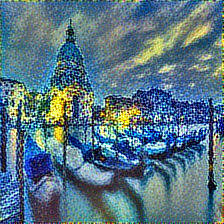

In [44]:
x = x.reshape((height, width, 3))

x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = x[:, :, ::-1]
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)